## Bibliotecas

In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import joblib  # Para salvar e carregar o modelo
from sklearn.svm import SVC
from sklearn.model_selection import KFold 


#importando bibliotecas
from tensorflow import keras
from sklearn.utils import shuffle
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,Bidirectional,Dropout
from keras.layers import AveragePooling1D
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.layers import Flatten
from sklearn import preprocessing
from sklearn.metrics import * 
import os
from imblearn.over_sampling import SMOTE #normalizacao da base
#Bibliotecas para rodar os algoritmos em modo classificação
from collections import Counter
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif



#implementando Focal loss
import tensorflow as tf
from tensorflow.keras import backend as K



2025-06-02 21:31:29.253003: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 21:31:29.368201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-02 21:31:29.430777: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-02 21:31:29.450601: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-02 21:31:29.536182: I tensorflow/core/platform/cpu_feature_guar

## Carregamento dos dados

In [2]:
df = pd.read_csv('reqTxt_pt.csv', header=None) #Report or file containing the set of training and test texts.

In [3]:
dfRequire = df.iloc[:,:] 

In [4]:
print(dfRequire.shape)
print(dfRequire.columns)
X = dfRequire[0]
print(X[0])
X = np.array(X)

print(len(X))

print('Train and test dataset loaded...')

(23313, 1)
Index([0], dtype='int64')
adicione ca contra literais de objeto em invocações de função a idéia aqui é que se nossos metadados capturarem um tipo como argumento de função, deveremos ser capazes de criar uma instância desse tipo como um literal de objeto como um argumento para uma invocação de função, por exemplop tiuicreatelabel ltpropertycaheregt código prediv
23313
Train and test dataset loaded...


In [5]:
y = pd.read_csv('estiDeep.data', header=None) #File containing the set of training and test labels.
y = np.array(y)
print ('Shape of label tensor:', y.shape)
print(y.dtype)

#Number of texts in train and test dataset 
MAX_LEN = 23313

kf = KFold(n_splits=10, shuffle=True, random_state=1000) 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 

Shape of label tensor: (23313, 1)
int64
KFold(n_splits=10, random_state=1000, shuffle=True)


In [6]:
#Realizando o mapeamento para a sequencia de fibonacci
fibonacci_labels = [1, 2, 3, 5, 8, 13, 20, 40, 100]
#arredondando para o valor mais próximo dos rótulos Fibonacci.
def map_to_fibonacci(estimate):
    if estimate <= 1.5:
        return 1
    elif estimate <= 2.5:
        return 2
    elif estimate <= 4:
        return 3
    elif estimate <= 6.5:
        return 5
    elif estimate <= 10.5:
        return 8
    elif estimate <= 16.5:
        return 13
    elif estimate <= 30:
        return 20
    elif estimate <= 70:
        return 40
    else:
        return 100



In [7]:
#Realizando agrupamento com classes menores
# Mapeamento com menos classes (agrupadas)
def map_to_fibonacci_grouped(estimate):
   
    if estimate in [1, 2, 3]:
        return 0
    elif estimate in [5, 8, 13]:
        return 1
    elif estimate in [20, 40, 100]:
        return 2
    else:
        return None


In [8]:
map_to_fibonacci_vec = np.vectorize(map_to_fibonacci)
fibonacci_labels = map_to_fibonacci_vec(y)
y_fibonacci = fibonacci_labels

In [9]:
#agrupando fibonacci
map_to_fibonacci_vec = np.vectorize(map_to_fibonacci_grouped)
fibonacci_labels = map_to_fibonacci_vec(y_fibonacci)
y_fibonacci = fibonacci_labels

In [10]:
y_fibonacci_values = y_fibonacci.flatten()
y_fibonacci_values.shape

(23313,)

In [11]:
unique, counts = np.unique(y_fibonacci_values, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Classe {label}: {count} exemplos")

Classe 0: 12440 exemplos
Classe 1: 9551 exemplos
Classe 2: 1322 exemplos


## Balanceando as classes

In [13]:
from imblearn.combine import SMOTETomek
from collections import Counter

In [14]:
### Carregando os dados de vetores embeddings gerados pelo xlnet
#embeddings_convert = pd.read_csv("output_en_embeddings_xlnet_.csv", header=None) #Xlnet
embeddings_convert = pd.read_csv("output_embeddings_xlnet_pt.csv", header=None) #Xlnet

X_embedding = embeddings_convert

In [15]:
X_embedding.shape

(23313, 768)

In [16]:
# 4. Limitar a quantidade de exemplos (por exemplo: 5000 aleatórios)
limite = 22000
df_sampled = X_embedding.copy()
df_sampled['classe'] = y_fibonacci_values
df_sampled = df_sampled.sample(n=limite, random_state=42)

X = df_sampled.drop(columns=['classe'])
y = df_sampled['classe']

print("Antes do balanceamento:", Counter(y))

Antes do balanceamento: Counter({0: 11752, 1: 9020, 2: 1228})


### Gerando dados com GANs!

In [17]:
# Selecionar apenas os exemplos da classe 2
classe2_df = df_sampled[df_sampled['classe'] == 2]

In [18]:
# Separar X e y da classe 2
X_classe2 = classe2_df.drop(columns=['classe']).values  # embeddings como np.array
y_classe2 = classe2_df['classe'].values  # array com rótulo 2 (todos iguais)

In [19]:
from tensorflow.keras import layers, Model, Sequential

In [20]:
embedding_dim = 768


In [21]:
# Hiperparâmetros
embedding_dim = X_classe2.shape[1]
latent_dim = 100
batch_size = 64
epochs = 5000
n_critic = 5
lambda_gp = 10  # peso da penalidade do gradiente

In [22]:
latent_dim = 256

In [22]:
# Gerador
def build_generator():
    model = Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(embedding_dim)
    ])
    return model

# Discriminador
def build_discriminator():
    model = Sequential([
        layers.Input(shape=(embedding_dim,)),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1)
    ])
    return model

In [23]:
# Instanciando modelos
generator = build_generator()
discriminator = build_discriminator()
#discriminator.compile(loss='binary_crossentropy',
#    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
#    metrics=['accuracy'])
# Otimizadores
g_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
c_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

I0000 00:00:1747258328.253273    4843 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747258328.381672    4843 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747258328.382088    4843 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747258328.385218    4843 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [24]:
# Gradient penalty
def gradient_penalty(critic, real_samples, fake_samples):
    alpha = tf.random.uniform((real_samples.shape[0], 1), 0.0, 1.0)
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = critic(interpolated)
    grads = gp_tape.gradient(pred, interpolated)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-10)
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

In [25]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,313 (2.00 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
print("Discriminator compiled loss:", discriminator.loss)
print("Is compiled?", hasattr(discriminator, 'train_function'))


Discriminator compiled loss: None
Is compiled? True


In [66]:
X_real = np.random.normal(size=(64, embedding_dim))
y_real = np.ones((64, 1))

# Simula dados falsos
X_fake = np.random.normal(size=(64, embedding_dim))
y_fake = np.zeros((64, 1))

# Tenta treinar o discriminador
loss_real = discriminator.train_on_batch(X_real, y_real)
loss_fake = discriminator.train_on_batch(X_fake, y_fake)

print("Loss real:", loss_real)
print("Loss fake:", loss_fake)

AttributeError: 'NoneType' object has no attribute 'update_state'

In [ ]:
# Conectando tudo na GAN
#z = layers.Input(shape=(latent_dim,))
#generated_embedding = generator(z)
#discriminator.trainable = False  # congela D ao treinar G
#validity = discriminator(generated_embedding)
#gan = Model(z, validity)
#gan.compile(optimizer="adam", loss="binary_crossentropy")

In [27]:
# Instanciar
generator = build_generator()
critic = build_discriminator()

In [71]:
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_classe2 = scaler.fit_transform(X_classe2)


In [29]:
# Loop de treino
for epoch in range(epochs):
    for _ in range(n_critic):
        idx = np.random.randint(0, X_classe2.shape[0], batch_size)
        real_samples = X_classe2[idx]
        noise = tf.random.normal((batch_size, latent_dim))
        fake_samples = generator(noise)

        with tf.GradientTape() as tape:
            real_output = critic(real_samples)
            fake_output = critic(fake_samples)
            gp = gradient_penalty(critic, real_samples, fake_samples)

            c_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + lambda_gp * gp

        grads = tape.gradient(c_loss, critic.trainable_variables)
        c_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

    # Treinamento do Gerador
    noise = tf.random.normal((batch_size, latent_dim))
    with tf.GradientTape() as tape:
        fake_samples = generator(noise)
        fake_output = critic(fake_samples)
        g_loss = -tf.reduce_mean(fake_output)

    grads = tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Critic loss: {c_loss.numpy():.4f} | Generator loss: {g_loss.numpy():.4f}")

Epoch 0 | Critic loss: -0.3268 | Generator loss: 0.6283
Epoch 200 | Critic loss: -22.4038 | Generator loss: -5.3453
Epoch 400 | Critic loss: -24.2185 | Generator loss: -5.2857
Epoch 600 | Critic loss: -23.8827 | Generator loss: -5.3123
Epoch 800 | Critic loss: -24.2135 | Generator loss: -6.3748
Epoch 1000 | Critic loss: -22.9341 | Generator loss: -5.0839
Epoch 1200 | Critic loss: -22.8253 | Generator loss: -6.5457
Epoch 1400 | Critic loss: -22.1538 | Generator loss: -7.1250
Epoch 1600 | Critic loss: -20.8628 | Generator loss: -5.4129
Epoch 1800 | Critic loss: -18.7062 | Generator loss: -5.1666
Epoch 2000 | Critic loss: -17.7582 | Generator loss: -4.6803
Epoch 2200 | Critic loss: -17.1229 | Generator loss: -4.2680
Epoch 2400 | Critic loss: -15.9695 | Generator loss: -4.9223
Epoch 2600 | Critic loss: -17.2550 | Generator loss: -3.8341
Epoch 2800 | Critic loss: -17.2704 | Generator loss: -4.5053
Epoch 3000 | Critic loss: -16.6666 | Generator loss: -3.7234
Epoch 3200 | Critic loss: -16.137

In [30]:
generator.save("generator_model_wgan_en.h5")
critic.save("discriminator_model_wgan_en.h5")

In [24]:
from tensorflow.keras.models import load_model

# Carregar os modelos salvos
generator = load_model("generator_model_wgan_.h5")
discriminator = load_model("generator_model_wgan_.h5")

#generator = load_model("generator_model_wgan_en.h5")
#discriminator = load_model("generator_model_wgan_en.h5")
#gan = load_model("generator_model_wgan_.h5")  # Se você salvou o modelo composto

In [ ]:
generator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 768)            │       393,984 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,432 (2.27 MB)

 Trainable params: 592,896 (2.26 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [25]:
noise = np.random.normal(0, 1, (8229, latent_dim))
synthetic_embeddings = generator.predict(noise)

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [26]:
synthetic_embeddings_norm = scaler.inverse_transform(synthetic_embeddings)

In [27]:
synthetic_embeddings_norm.shape

(8229, 768)

In [28]:
X_classe2
synthetic_embeddings_norm

array([[-2.1655843 ,  1.4326475 , -1.5352685 , ..., -1.585381  ,
         1.5501965 ,  1.8539213 ],
       [-0.24854265, -2.7797868 ,  0.44304076, ..., -0.88888896,
         1.5617944 , -0.2521257 ],
       [-0.7775252 , -0.06662228, -2.3587232 , ..., -1.5124559 ,
         1.6448355 , -0.71204466],
       ...,
       [-1.7259033 ,  0.12925552,  0.70718455, ..., -1.6431689 ,
         0.1035464 , -1.0471673 ],
       [ 0.08136813,  1.4974412 , -0.5213047 , ..., -1.831562  ,
         2.5841546 ,  2.1914566 ],
       [-1.2001326 ,  1.8892733 , -1.0182261 , ..., -2.1706548 ,
         1.5698664 ,  0.55751336]], dtype=float32)

In [72]:
# Suponha que:
# - real_embeddings: array NumPy com os embeddings reais
# - synthetic_embeddings: array NumPy com os embeddings sintéticos

import numpy as np

# Se necessário, use np.vstack() para concatenar os embeddings
X_similaridade = np.vstack([X_classe2, synthetic_embeddings_norm])

# Crie os rótulos: 0 para real, 1 para sintético
y_similaridade = np.array([0] * len(X_classe2) + [1] * len(synthetic_embeddings_norm))


In [73]:
# t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded_similaridade = tsne.fit_transform(X_similaridade)


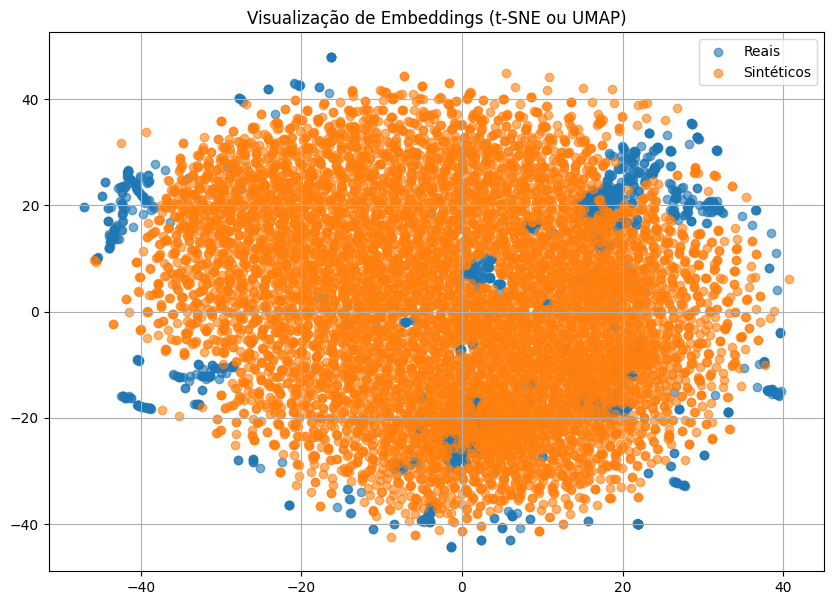

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(X_embedded_similaridade[y_similaridade==0, 0], X_embedded_similaridade[y_similaridade==0, 1], label='Reais', alpha=0.6)
plt.scatter(X_embedded_similaridade[y_similaridade==1, 0], X_embedded_similaridade[y_similaridade==1, 1], label='Sintéticos', alpha=0.6)
plt.title('Visualização de Embeddings (t-SNE ou UMAP)')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
def ValidaAmostragem(X,y):
    clf = LogisticRegression()
    score = cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()

    return print(f"Acurácia de separação real vs sintético: {score:.2f}")


In [77]:
ValidaAmostragem(X_similaridade, y_similaridade)

Acurácia de separação real vs sintético: 1.00


In [29]:
y_fake = np.full((8229,), 2)

In [30]:
# Concatenar os embeddings
X_combined = np.vstack((X, synthetic_embeddings))

# Concatenar os rótulos
y_combined = np.concatenate((y, y_fake))

In [ ]:
unique, counts = np.unique(y_combined, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Classe {label}: {count} exemplos")

Classe 0: 11752 exemplos
Classe 1: 9020 exemplos
Classe 2: 9457 exemplos


In [75]:
# 5. Aplicar SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

print("Depois do balanceamento:", Counter(y_resampled))

Depois do balanceamento: Counter({2: 11752, 0: 11413, 1: 11413})


In [76]:
X_classe_2_smote = X_resampled[y_resampled == 2]

In [77]:
# Suponha que:
# - real_embeddings: array NumPy com os embeddings reais
# - synthetic_embeddings: array NumPy com os embeddings sintéticos

import numpy as np

# Se necessário, use np.vstack() para concatenar os embeddings
X_similaridade = np.vstack([X_classe2, X_classe_2_smote])

# Crie os rótulos: 0 para real, 1 para sintético
y_similaridade = np.array([0] * len(X_classe2) + [1] * len(X_classe_2_smote))


In [78]:
# t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded_similaridade = tsne.fit_transform(X_similaridade)


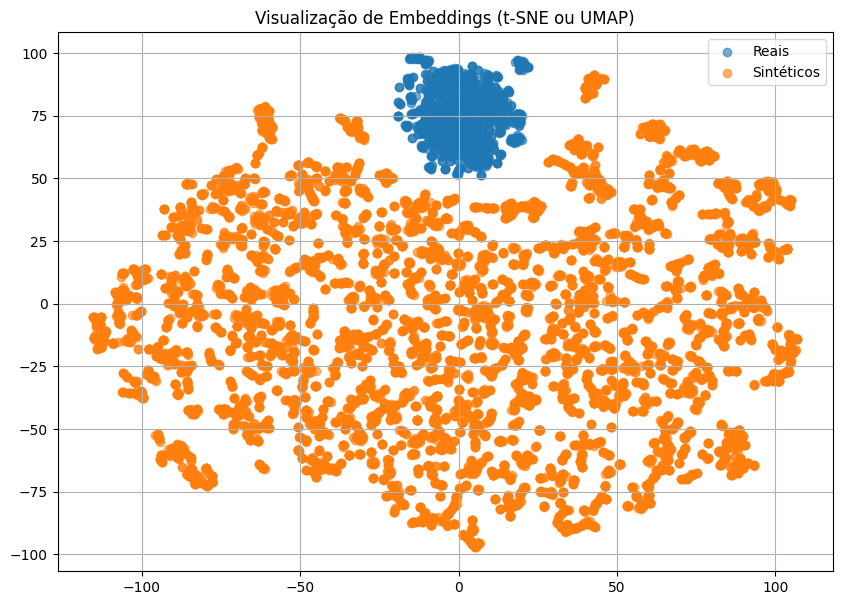

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(X_embedded_similaridade[y_similaridade==0, 0], X_embedded_similaridade[y_similaridade==0, 1], label='Reais', alpha=0.6)
plt.scatter(X_embedded_similaridade[y_similaridade==1, 0], X_embedded_similaridade[y_similaridade==1, 1], label='Sintéticos', alpha=0.6)
plt.title('Visualização de Embeddings (t-SNE ou UMAP)')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression()
score = cross_val_score(clf, X_similaridade, y_similaridade, cv=5, scoring='accuracy').mean()

print(f"Acurácia de separação real vs sintético: {score:.2f}")

Acurácia de separação real vs sintético: 1.00


In [81]:
print(f"Acurácia de separação real vs sintético: {score:.2f}")

Acurácia de separação real vs sintético: 1.00


In [70]:
type(X_combined)

numpy.ndarray

## Preparando entrada do modelo

In [31]:
#tornando X um array numpy
X_res_values = X_embedding.values

# Defina o número de sentenças
num_sentences = 115
num_samples = X_res_values.shape[0]
embedding_dim = X_res_values.shape[1]

# Truncar e reformular os dados para a entrada do modelo
needed_samples = (num_samples // num_sentences) * num_sentences
X_truncated = X_res_values[:needed_samples]
y_truncated = y_fibonacci_values[:needed_samples]

# Reformulando X para o formato adequado para o LSTM
X_reshaped = X_truncated.reshape(-1, num_sentences, embedding_dim)
y_truncated_resized = y_truncated[:X_reshaped.shape[0]]
# Inicialização para armazenar as métricas
all_y_test = []
all_y_pred = []

# Definir número de classes para a camada Softmax
num_classes = 3  # Correspondente a 9 classes (0-8)

#definindo variavel para realizar cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=1000)
#kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1000)

In [84]:
y_truncated.unique()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [32]:
#convertendo as classes originais em 0,1,2,3,4,5,6,7,8
# Classes originais
original_classes = [0,1,2]
#original_classes = [1, 2, 3]
class_to_index = {cls: idx for idx, cls in enumerate(original_classes)}
index_to_class = {idx: cls for idx, cls in enumerate(original_classes)}

y_encoded = np.array([class_to_index[y_fibonacci_values] for y_fibonacci_values in y_truncated])

In [33]:
import os
import yaml
from ultralytics import YOLO
import torch

In [34]:
# Verifica se a GPU está disponível, se não, usa a CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo selecionado: {device}")

Dispositivo selecionado: cpu


/home/daniel/mestrado/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [44]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.config.experimental.reset_memory_stats("GPU:0")

In [45]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [46]:
import tensorflow as tf

# Verificando se há GPU disponível
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow está usando GPU?" , tf.test.is_gpu_available(cuda_only=True))

# (Opcional) Para listar o nome da GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow está usando GPU? True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16623717503326121519
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6585647104
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3869729345239595519
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


I0000 00:00:1747260206.221031    4843 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747260206.221555    4843 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747260206.221841    4843 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747260206.222199    4843 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [47]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [108]:
from imblearn.over_sampling import SMOTE

In [ ]:
import random
# Função para definir seed globalmente
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

#implementando Focal Loss
# Função para implementar o Focal Loss
def focal_loss(gamma=2., alpha=None):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])

        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())  # Prevenindo log(0)
        cross_entropy = -y_true * tf.math.log(y_pred)

        if alpha is not None:
            alpha_tensor = tf.constant(alpha, dtype=tf.float32)
            alpha_factor = y_true * alpha_tensor
            cross_entropy *= alpha_factor

        weight = tf.pow(1. - y_pred, gamma)  # Focal loss weight
        loss = weight * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return focal_loss_fixed

# Inicializando listas para armazenar métricas e tempos
vetAccuracyDeep = []
vetPrecisionDeep = []
vetRecallDeep = []
vetF1Deep = []
vetBalancedAccuracyDeep = []  # Lista para armazenar a Balanced Accuracy
training_times = []
inference_times = []
all_y_test_Deep = []
all_y_pred_Deep = []

# Definindo o KFold para cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lista de seeds diferentes para testar
# Define uma seed mestra para gerar seeds aleatórias controladas
random.seed(42)
seeds = [random.randint(0, 100000) for _ in range(5)]
print("Seeds fixas e reprodutíveis:", seeds)

# Realizando múltiplos experimentos com diferentes seeds
for seed in seeds:
    print(f"Executando experimento com seed: {seed}")
    
    # Inicializando o seed
    set_seed(seed)




      # Inicializando listas para armazenar as métricas para cada seed
    vetAccuracyTemp = []
    vetPrecisionTemp = []
    vetRecallTemp = []
    vetF1Temp = []
    vetBalancedAccuracyTemp = []
    training_times_temp = []
    inference_times_temp = []

    # Definindo o KFold para cross-validation (você pode usar outro tipo de validacao se necessário)
    #kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X_truncated, y_encoded):  # X_truncated e y_encoded são os dados e rótulos
        print(X_truncated.shape)
        print(X_truncated.size)   
        x_train, x_test = X_truncated[train_index], X_truncated[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]
        print(np.unique(y_train))
        print(np.unique(y_test))
        print(x_train.shape)  # Para x_train
        print(x_test.shape)   # Para x_test
        n_sentence = 1


        # Adicionando as amostras sintéticas somente ao treino
        x_train = np.concatenate([x_train, synthetic_embeddings_norm], axis=0)
        y_train = np.concatenate([y_train, y_fake], axis=0)
        
        print("Treino balanceado:", Counter(y_train))
        print("Teste desbalanceado:", Counter(y_test))
        # Agora sim, faça o reshape após adicionar as amostras sintéticas
        x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

        # Redimensionando os dados
       # x_train = x_train.reshape(x_train.shape[0], n_sentence, x_train.shape[1])  # (38947, 1, 768)
        #smote = SMOTE(sampling_strategy={2: 9551}, random_state=42)
        #x_train_res, y_train_res = smote.fit_resample(x_train.reshape(x_train.shape[0], -1), y_train)
        #x_train_res = x_train_res.reshape(x_train_res.shape[0], n_sentence, -1)
        #x_test = x_test.reshape(x_test.shape[0], n_sentence, x_test.shape[1])  # (4328, 1, 768)

        # Aplicando SMOTE para balanceamento de classes no conjunto de treino
        #smote = SMOTE(random_state=42)
        #x_train_res, y_train_res = smote.fit_resample(x_train.reshape(x_train.shape[0], -1), y_train)
        #x_train_res = x_train_res.reshape(x_train_res.shape[0], n_sentence, -1)  # Redimensionando novamente após SMOTE
        #x_train = x_train.reshape(x_train.shape[0], -1)  # (38947, 1, 768)
        #x_test = x_test.reshape(x_test.shape[0], -1)  # (4328, 1, 768)
        #x_train = x_train.reshape(x_train.shape[0], 1, -1)  # Redimensionando os dados de entrada para (n_samples, 1, n_features)
        #x_test = x_test.reshape(x_test.shape[0], 1, -1)  # Redimensionando os dados de teste da mesma forma
        # Redimensionando os dados
       # x_train = x_train.reshape(x_train.shape[0], -1)  # (38947, 1, 768)
        #x_test = x_test.reshape(x_test.shape[0], -1)  # (4328, 1, 768)
         # Aplicando SMOTE para balanceamento de classes no conjunto de treino
        #smote = SMOTE(random_state=42)
       
        #x_train = x_train.reshape(x_train.shape[0], n_sentence, -1)  # Redimensionando para o formato correto
        # Definindo o modelo

        
        modelDeepClass = Sequential([
            #LSTM(100, dropout=0.5, recurrent_dropout=0.3, return_sequences=False),
            Bidirectional(LSTM(200, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)),
            LSTM(100, dropout=0.3, recurrent_dropout=0.2),
            Dense(50, activation='relu'),
            Dense(num_classes, activation='softmax')
            #LSTM(200, dropout=0.5, recurrent_dropout=0.3, return_sequences=False),
            #Dense(50, activation='relu'),
            #Dense(10, activation='relu'),
            #Dense(num_classes, activation='softmax')
        ])

        adam = Adam(learning_rate=0.001)
        #modelDeepClass.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
        #adicionado Focal Loss
        modelDeepClass.compile(loss=focal_loss(gamma=2.,  alpha=[0.2, 0.2, 0.6]), optimizer=adam, metrics=['accuracy'])

        # Early stopping
        es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50, restore_best_weights=True)
        classes = np.unique(y_train)
        weights = compute_class_weight('balanced', classes=classes, y=y_train)
        class_weight_dict = dict(zip(classes, weights))
        # Treinando o modelo
        start_training = time.time()
        modelDeepClass.fit(
            x_train, y_train,
            batch_size=128,
            epochs=30,
            #validation_split=0.2,  # Usando 20% dos dados de treino como conjunto de validação
            shuffle=True,  # Embaralhando os dados antes de dividi
            validation_data=(x_test, y_test),
            callbacks=[es],
            verbose=0,
            class_weight = class_weight_dict
        )
        end_training = time.time()
        training_time = end_training - start_training
        #training_times.append(training_time)

        # Fazendo previsões e medindo o tempo
        start_inference = time.time()
        y_pred = modelDeepClass.predict(x_test)
        end_inference = time.time()
        inference_time = end_inference - start_inference
        #inference_times.append(inference_time)

        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculando métricas
        accuracy = accuracy_score(y_test, y_pred_classes)
        class_report = classification_report(y_test, y_pred_classes, output_dict=True)

        # Calculando a Balanced Accuracy
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred_classes)

        vetAccuracyTemp.append(accuracy)
        vetPrecisionTemp.append(class_report['macro avg']['precision'])
        vetRecallTemp.append(class_report['macro avg']['recall'])
        vetF1Temp.append(class_report['macro avg']['f1-score'])
        vetBalancedAccuracyTemp.append(balanced_accuracy)

        all_y_test_Deep.extend(y_test)
        all_y_pred_Deep.extend(y_pred_classes)
        training_times_temp.append(training_time)
        inference_times_temp.append(inference_time)

# Calculando a média e o desvio padrão para as métricas de cada seed
    vetAccuracyDeep.append(np.mean(vetAccuracyTemp))
    vetPrecisionDeep.append(np.mean(vetPrecisionTemp))
    vetRecallDeep.append(np.mean(vetRecallTemp))
    vetF1Deep.append(np.mean(vetF1Temp))
    vetBalancedAccuracyDeep.append(np.mean(vetBalancedAccuracyTemp))

    training_times.append(np.mean(training_times_temp))
    inference_times.append(np.mean(inference_times_temp))

# Relatório final de métricas
print(f"Média Accuracy: {np.nanmean(vetAccuracyDeep):.4f} ± {np.nanstd(vetAccuracyDeep):.4f}")
print(f"Média Precision: {np.nanmean(vetPrecisionDeep):.4f} ± {np.nanstd(vetPrecisionDeep):.4f}")
print(f"Média Recall: {np.nanmean(vetRecallDeep):.4f} ± {np.nanstd(vetRecallDeep):.4f}")
print(f"Média F1-Score: {np.mean(vetF1Deep):.4f} ± {np.nanstd(vetF1Deep):.4f}")
print(f"Média Balanced Accuracy: {np.nanmean(vetBalancedAccuracyDeep):.4f} ± {np.nanstd(vetBalancedAccuracyDeep):.4f}")
print(f"Tempo médio de treinamento: {np.nanmean(training_times):.2f} ± {np.nanstd(training_times):.2f} segundos")
print(f"Tempo médio de inferência: {np.nanmean(inference_times):.2f} ± {np.nanstd(inference_times):.2f} segundos")


Seeds fixas e reprodutíveis: [83810, 14592, 3278, 97196, 36048]
Executando experimento com seed: 83810
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(20907, 768)
(2323, 768)
Treino balanceado: Counter({0: 11138, 2: 9419, 1: 8579})
Teste desbalanceado: Counter({0: 1238, 1: 953, 2: 132})


ValueError: Exception encountered when calling AveragePooling1D.call().

[1mNegative dimension size caused by subtracting 100 from 1 for '{{node sequential_82_1/average_pooling1d_1/AvgPool1D}} = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 1, 100, 1], padding="VALID", strides=[1, 1, 100, 1]](sequential_82_1/average_pooling1d_1/AvgPool1D/ExpandDims)' with input shapes: [?,1,1,768].[0m

Arguments received by AveragePooling1D.call():
  • inputs=tf.Tensor(shape=(None, 1, 768), dtype=float32)

In [42]:
print(f"Média Accuracy: {np.nanmean(vetAccuracyDeep):.4f} ± {np.nanstd(vetAccuracyDeep):.4f}")
print(f"Média Precision: {np.nanmean(vetPrecisionDeep):.4f} ± {np.nanstd(vetPrecisionDeep):.4f}")
print(f"Média Recall: {np.nanmean(vetRecallDeep):.4f} ± {np.nanstd(vetRecallDeep):.4f}")
print(f"Média F1-Score: {np.mean(vetF1Deep):.4f} ± {np.nanstd(vetF1Deep):.4f}")
print(f"Média Balanced Accuracy: {np.nanmean(vetBalancedAccuracyDeep):.4f} ± {np.nanstd(vetBalancedAccuracyDeep):.4f}")
print(f"Tempo médio de treinamento: {np.nanmean(training_times):.2f} ± {np.nanstd(training_times):.2f} segundos")
print(f"Tempo médio de inferência: {np.nanmean(inference_times):.2f} ± {np.nanstd(inference_times):.2f} segundos")

Média Accuracy: 0.5856 ± 0.0015
Média Precision: 0.5231 ± 0.0106
Média Recall: 0.4562 ± 0.0040
Média F1-Score: 0.4635 ± 0.0063
Média Balanced Accuracy: 0.4562 ± 0.0040
Tempo médio de treinamento: 94.49 ± 1.47 segundos
Tempo médio de inferência: 1.97 ± 0.13 segundos


In [49]:
#modelo ingles
print(f"Média Accuracy: {np.nanmean(vetAccuracyDeep):.4f} ± {np.nanstd(vetAccuracyDeep):.4f}")
print(f"Média Precision: {np.nanmean(vetPrecisionDeep):.4f} ± {np.nanstd(vetPrecisionDeep):.4f}")
print(f"Média Recall: {np.nanmean(vetRecallDeep):.4f} ± {np.nanstd(vetRecallDeep):.4f}")
print(f"Média F1-Score: {np.mean(vetF1Deep):.4f} ± {np.nanstd(vetF1Deep):.4f}")
print(f"Média Balanced Accuracy: {np.nanmean(vetBalancedAccuracyDeep):.4f} ± {np.nanstd(vetBalancedAccuracyDeep):.4f}")
print(f"Tempo médio de treinamento: {np.nanmean(training_times):.2f} ± {np.nanstd(training_times):.2f} segundos")
print(f"Tempo médio de inferência: {np.nanmean(inference_times):.2f} ± {np.nanstd(inference_times):.2f} segundos")

Média Accuracy: 0.6197 ± 0.0012
Média Precision: 0.5612 ± 0.0087
Média Recall: 0.5275 ± 0.0039
Média F1-Score: 0.5348 ± 0.0032
Média Balanced Accuracy: 0.5275 ± 0.0039
Tempo médio de treinamento: 94.95 ± 5.17 segundos
Tempo médio de inferência: 1.95 ± 0.13 segundos


In [52]:
all_y_pred_Deep

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,


In [50]:
import joblib
file_name = 'model_portugues_classificacao_v1_05_25_en.pkl' 
joblib.dump(modelDeepClass, file_name) 

['model_portugues_classificacao_v1_05_25_en.pkl']

In [37]:
modelDeepClass.save('model_classificacao_v1_05_25_pt.h5')

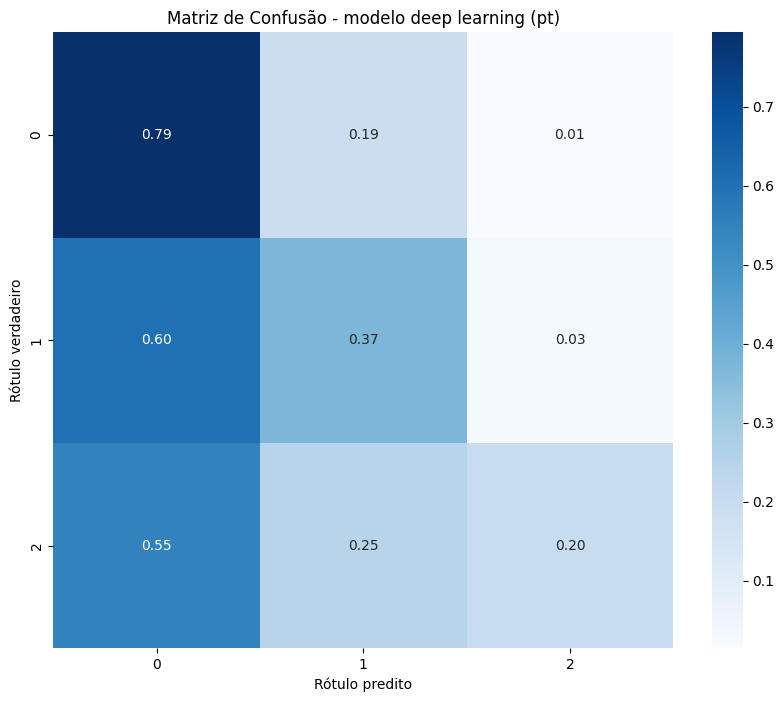

In [111]:


# Definir as classes do experimento E5


# Converter as previsões para classes discretas

#all_y_test_Deep, all_y_pred_Deep,
#classes = np.array([1, 2, 3, 5, 8, 13, 20, 40, 100])
classes = np.array([0, 1, 2])

# Gerar a matriz de confusão
matriz_confusao_model = confusion_matrix(all_y_test_Deep, all_y_pred_Deep, labels=classes)

# Calcular a proporção para cada classe verdadeira (linha)
matriz_confusao_proporcao_model = matriz_confusao_model.astype('float') / matriz_confusao_model.sum(axis=1)[:, np.newaxis]

# Exibir a matriz de confusão usando seaborn para visualização
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusao_proporcao_model, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Rótulo predito')
plt.ylabel('Rótulo verdadeiro')
plt.title('Matriz de Confusão - modelo deep learning (pt)')
plt.show()

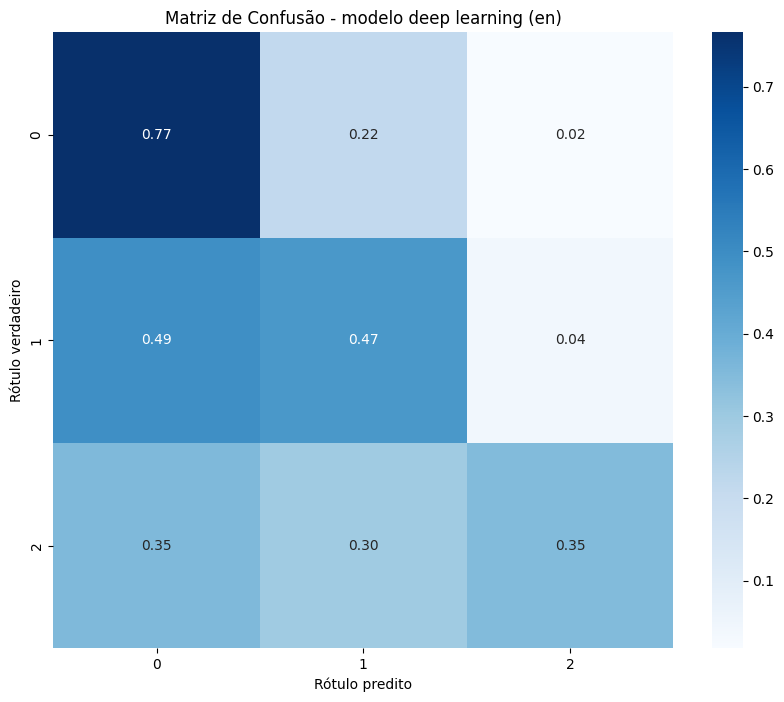

In [51]:


# Definir as classes do experimento E5


# Converter as previsões para classes discretas

#all_y_test_Deep, all_y_pred_Deep,
#classes = np.array([1, 2, 3, 5, 8, 13, 20, 40, 100])
classes = np.array([0, 1, 2])

# Gerar a matriz de confusão
matriz_confusao_model = confusion_matrix(all_y_test_Deep, all_y_pred_Deep, labels=classes)

# Calcular a proporção para cada classe verdadeira (linha)
matriz_confusao_proporcao_model = matriz_confusao_model.astype('float') / matriz_confusao_model.sum(axis=1)[:, np.newaxis]

# Exibir a matriz de confusão usando seaborn para visualização
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusao_proporcao_model, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Rótulo predito')
plt.ylabel('Rótulo verdadeiro')
plt.title('Matriz de Confusão - modelo deep learning (en)')
plt.show()

### Resultado com 3 classes

In [34]:
print(f"Média Accuracy: {np.nanmean(vetAccuracyDeep):.4f} ± {np.nanstd(vetAccuracyDeep):.4f}")
print(f"Média Precision: {np.nanmean(vetPrecisionDeep):.4f} ± {np.nanstd(vetPrecisionDeep):.4f}")
print(f"Média Recall: {np.nanmean(vetRecallDeep):.4f} ± {np.nanstd(vetRecallDeep):.4f}")
print(f"Média F1-Score: {np.mean(vetF1Deep):.4f} ± {np.nanstd(vetF1Deep):.4f}")
print(f"Média Balanced Accuracy: {np.nanmean(vetBalancedAccuracyDeep):.4f} ± {np.nanstd(vetBalancedAccuracyDeep):.4f}")
print(f"Tempo médio de treinamento: {np.nanmean(training_times):.2f} ± {np.nanstd(training_times):.2f} segundos")
print(f"Tempo médio de inferência: {np.nanmean(inference_times):.2f} ± {np.nanstd(inference_times):.2f} segundos")

Média Accuracy: 0.5964 ± 0.0018
Média Precision: 0.6107 ± 0.0097
Média Recall: 0.4459 ± 0.0032
Média F1-Score: 0.4616 ± 0.0056
Média Balanced Accuracy: 0.4459 ± 0.0032
Tempo médio de treinamento: 91.72 ± 7.55 segundos
Tempo médio de inferência: 1.90 ± 0.10 segundos


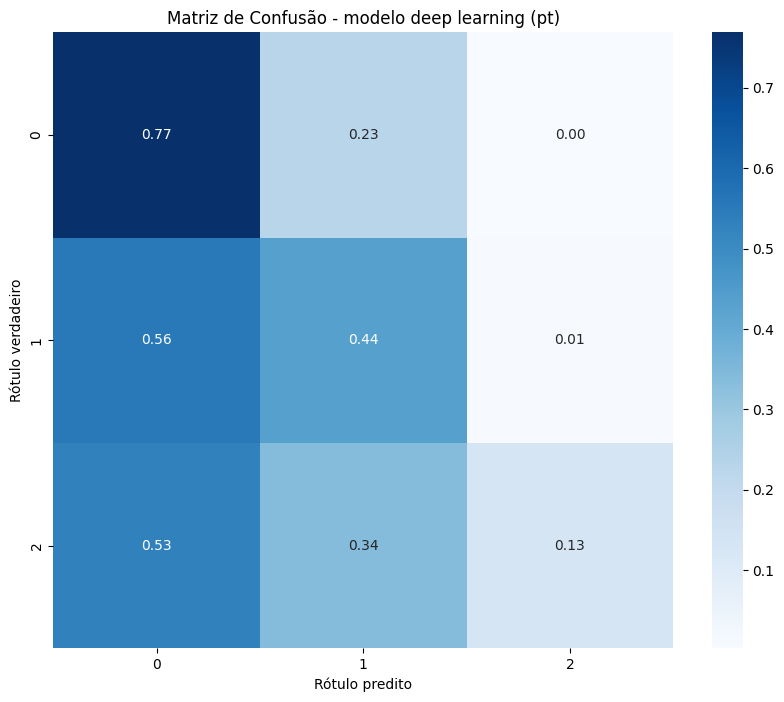

In [48]:


# Definir as classes do experimento E5


# Converter as previsões para classes discretas

#all_y_test_Deep, all_y_pred_Deep,
#classes = np.array([1, 2, 3, 5, 8, 13, 20, 40, 100])
classes = np.array([0, 1, 2])

# Gerar a matriz de confusão
matriz_confusao_model = confusion_matrix(all_y_test_Deep, all_y_pred_Deep, labels=classes)

# Calcular a proporção para cada classe verdadeira (linha)
matriz_confusao_proporcao_model = matriz_confusao_model.astype('float') / matriz_confusao_model.sum(axis=1)[:, np.newaxis]

# Exibir a matriz de confusão usando seaborn para visualização
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusao_proporcao_model, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Rótulo predito')
plt.ylabel('Rótulo verdadeiro')
plt.title('Matriz de Confusão - modelo deep learning (pt)')
plt.show()

In [37]:
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix
import pandas as pd



# Aplica o teste qui-quadrado à matriz de confusão
chi2, p, dof, expected = chi2_contingency(matriz_confusao_model)

print(f"Qui-quadrado: {chi2:.4f}")
print(f"p-valor: {p:.4f}")

Qui-quadrado: 14292.2490
p-valor: 0.0000


In [140]:
del modelDeepClass

### Dados Balanceados com GANs

In [81]:

print(f"Média Accuracy: {np.nanmean(vetAccuracyDeep):.4f} ± {np.nanstd(vetAccuracyDeep):.4f}")
print(f"Média Precision: {np.nanmean(vetPrecisionDeep):.4f} ± {np.nanstd(vetPrecisionDeep):.4f}")
print(f"Média Recall: {np.nanmean(vetRecallDeep):.4f} ± {np.nanstd(vetRecallDeep):.4f}")
print(f"Média F1-Score: {np.mean(vetF1Deep):.4f} ± {np.nanstd(vetF1Deep):.4f}")
print(f"Média Balanced Accuracy: {np.nanmean(vetBalancedAccuracyDeep):.4f} ± {np.nanstd(vetBalancedAccuracyDeep):.4f}")
print(f"Tempo médio de treinamento: {np.nanmean(training_times):.2f} ± {np.nanstd(training_times):.2f} segundos")
print(f"Tempo médio de inferência: {np.nanmean(inference_times):.2f} ± {np.nanstd(inference_times):.2f} segundos")

Média Accuracy: 0.7060 ± 0.0005
Média Precision: 0.7221 ± 0.0004
Média Recall: 0.6953 ± 0.0016
Média F1-Score: 0.6984 ± 0.0025
Média Balanced Accuracy: 0.6953 ± 0.0016
Tempo médio de treinamento: 83.83 ± 3.17 segundos
Tempo médio de inferência: 2.15 ± 0.27 segundos


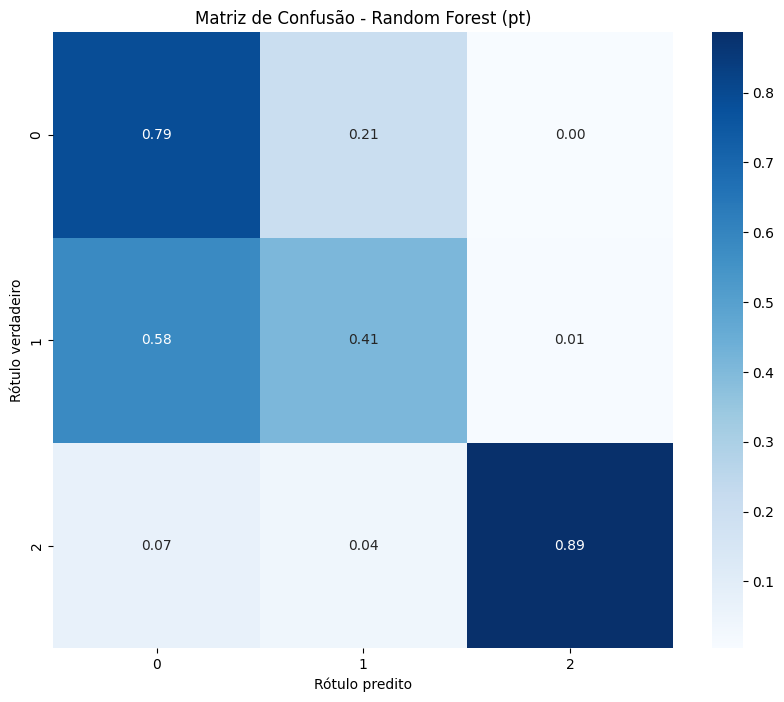

In [82]:


# Definir as classes do experimento E5


# Converter as previsões para classes discretas

#all_y_test_Deep, all_y_pred_Deep,
#classes = np.array([1, 2, 3, 5, 8, 13, 20, 40, 100])
classes = np.array([0, 1, 2])

# Gerar a matriz de confusão
matriz_confusao_rf = confusion_matrix(all_y_test_Deep, all_y_pred_Deep, labels=classes)

# Calcular a proporção para cada classe verdadeira (linha)
matriz_confusao_proporcao_rf = matriz_confusao_rf.astype('float') / matriz_confusao_rf.sum(axis=1)[:, np.newaxis]

# Exibir a matriz de confusão usando seaborn para visualização
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusao_proporcao_rf, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Rótulo predito')
plt.ylabel('Rótulo verdadeiro')
plt.title('Matriz de Confusão - Random Forest (pt)')
plt.show()

### Random Forest com GANs

In [116]:
from sklearn.ensemble import RandomForestClassifier
import random
import numpy as np
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Função para definir seed globalmente
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

# Inicializando listas para armazenar métricas e tempos
vetAccuracyRF = []
vetPrecisionRF = []
vetRecallRF = []
vetF1RF = []
vetBalancedAccuracyRF = []
training_times = []
inference_times = []
all_y_test_RF = []
all_y_pred_RF = []

# Definindo o KFold para cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lista de seeds diferentes para testar
random.seed(42)
seeds = [random.randint(0, 100000) for _ in range(5)]
print("Seeds fixas e reprodutíveis:", seeds)

# Realizando múltiplos experimentos com diferentes seeds
for seed in seeds:
    print(f"Executando experimento com seed: {seed}")
    
    # Inicializando o seed
    set_seed(seed)

    # Inicializando listas para armazenar as métricas para cada seed
    vetAccuracyTemp = []
    vetPrecisionTemp = []
    vetRecallTemp = []
    vetF1Temp = []
    vetBalancedAccuracyTemp = []
    training_times_temp = []
    inference_times_temp = []

    for train_index, test_index in kf.split(X_truncated, y_encoded):  
        print(X_truncated.shape)
        print(X_truncated.size)
        
        x_train, x_test = X_truncated[train_index], X_truncated[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        print(np.unique(y_train))
        print(np.unique(y_test))
        print(x_train.shape)
        print(x_test.shape)

        # Adicionando as amostras sintéticas somente ao treino
        x_train = np.concatenate([x_train, synthetic_embeddings_norm], axis=0)
        y_train = np.concatenate([y_train, y_fake], axis=0)

        # Não precisa fazer reshape para (1, features) igual na rede neural

        # Definindo o modelo Random Forest
        modelRF = RandomForestClassifier(
            n_estimators=100, 
            random_state=seed, 
            class_weight='balanced',  # Trata classes desbalanceadas automaticamente
            n_jobs=-1
        )

        # Treinando o modelo
        start_training = time.time()
        modelRF.fit(x_train, y_train)
        end_training = time.time()
        training_time = end_training - start_training

        # Fazendo previsões
        start_inference = time.time()
        y_pred_classes = modelRF.predict(x_test)
        end_inference = time.time()
        inference_time = end_inference - start_inference

        # Calculando métricas
        accuracy = accuracy_score(y_test, y_pred_classes)
        class_report = classification_report(y_test, y_pred_classes, output_dict=True)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred_classes)

        vetAccuracyTemp.append(accuracy)
        vetPrecisionTemp.append(class_report['macro avg']['precision'])
        vetRecallTemp.append(class_report['macro avg']['recall'])
        vetF1Temp.append(class_report['macro avg']['f1-score'])
        vetBalancedAccuracyTemp.append(balanced_accuracy)

        all_y_test_RF.extend(y_test)
        all_y_pred_RF.extend(y_pred_classes)
        training_times_temp.append(training_time)
        inference_times_temp.append(inference_time)

    # Calculando a média e o desvio padrão para as métricas de cada seed
    vetAccuracyRF.append(np.mean(vetAccuracyTemp))
    vetPrecisionRF.append(np.mean(vetPrecisionTemp))
    vetRecallRF.append(np.mean(vetRecallTemp))
    vetF1RF.append(np.mean(vetF1Temp))
    vetBalancedAccuracyRF.append(np.mean(vetBalancedAccuracyTemp))

    training_times.append(np.mean(training_times_temp))
    inference_times.append(np.mean(inference_times_temp))

# Relatório final de métricas
print(f"Média Accuracy: {np.nanmean(vetAccuracyRF):.4f} ± {np.nanstd(vetAccuracyRF):.4f}")
print(f"Média Precision: {np.nanmean(vetPrecisionRF):.4f} ± {np.nanstd(vetPrecisionRF):.4f}")
print(f"Média Recall: {np.nanmean(vetRecallRF):.4f} ± {np.nanstd(vetRecallRF):.4f}")
print(f"Média F1-Score: {np.nanmean(vetF1RF):.4f} ± {np.nanstd(vetF1RF):.4f}")
print(f"Média Balanced Accuracy: {np.nanmean(vetBalancedAccuracyRF):.4f} ± {np.nanstd(vetBalancedAccuracyRF):.4f}")
print(f"Tempo médio de treinamento: {np.nanmean(training_times):.2f} ± {np.nanstd(training_times):.2f} segundos")
print(f"Tempo médio de inferência: {np.nanmean(inference_times):.2f} ± {np.nanstd(inference_times):.2f} segundos")


Seeds fixas e reprodutíveis: [83810, 14592, 3278, 97196, 36048]
Executando experimento com seed: 83810
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(20907, 768)
(2323, 768)
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(20907, 768)
(2323, 768)
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(20907, 768)
(2323, 768)
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(20907, 768)
(2323, 768)
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(20907, 768)
(2323, 768)
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(20907, 768)
(2323, 768)
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(20907, 768)
(2323, 768)
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(20907, 768)
(2323, 768)
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(20907, 768)
(2323, 768)
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(20907, 768)
(2323, 768)
Executando experimento com seed: 14592
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(20907, 768)
(2323, 768)
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(20907, 768)
(2323, 768)
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(20907, 768)
(2323, 768)
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(

In [117]:

# Relatório final de métricas
print(f"Média Accuracy: {np.nanmean(vetAccuracyRF):.4f} ± {np.nanstd(vetAccuracyRF):.4f}")
print(f"Média Precision: {np.nanmean(vetPrecisionRF):.4f} ± {np.nanstd(vetPrecisionRF):.4f}")
print(f"Média Recall: {np.nanmean(vetRecallRF):.4f} ± {np.nanstd(vetRecallRF):.4f}")
print(f"Média F1-Score: {np.nanmean(vetF1RF):.4f} ± {np.nanstd(vetF1RF):.4f}")
print(f"Média Balanced Accuracy: {np.nanmean(vetBalancedAccuracyRF):.4f} ± {np.nanstd(vetBalancedAccuracyRF):.4f}")
print(f"Tempo médio de treinamento: {np.nanmean(training_times):.2f} ± {np.nanstd(training_times):.2f} segundos")
print(f"Tempo médio de inferência: {np.nanmean(inference_times):.2f} ± {np.nanstd(inference_times):.2f} segundos")

Média Accuracy: 0.5779 ± 0.0007
Média Precision: 0.6681 ± 0.0050
Média Recall: 0.3964 ± 0.0006
Média F1-Score: 0.3863 ± 0.0010
Média Balanced Accuracy: 0.3964 ± 0.0006
Tempo médio de treinamento: 20.93 ± 0.09 segundos
Tempo médio de inferência: 0.05 ± 0.00 segundos


### SVM com GANs

In [ ]:
import random
import time
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold

# Função para definir seed globalmente
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

# Inicializando listas para armazenar métricas e tempos
vetAccuracySVM = []
vetPrecisionSVM = []
vetRecallSVM = []
vetF1SVM = []
vetBalancedAccuracySVM = []
training_times = []
inference_times = []
all_y_test_SVM = []
all_y_pred_SVM = []

# Definindo o KFold para cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lista de seeds diferentes para testar
random.seed(42)
seeds = [random.randint(0, 100000) for _ in range(5)]
print("Seeds fixas e reprodutíveis:", seeds)

# Realizando múltiplos experimentos com diferentes seeds
for seed in seeds:
    print(f"Executando experimento com seed: {seed}")
    set_seed(seed)

    # Inicializando listas temporárias para cada experimento
    vetAccuracyTemp = []
    vetPrecisionTemp = []
    vetRecallTemp = []
    vetF1Temp = []
    vetBalancedAccuracyTemp = []
    training_times_temp = []
    inference_times_temp = []

    for train_index, test_index in kf.split(X_truncated, y_encoded):
        x_train, x_test = X_truncated[train_index], X_truncated[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Adicionando as amostras sintéticas apenas no treino
        x_train = np.concatenate([x_train, synthetic_embeddings], axis=0)
        y_train = np.concatenate([y_train, y_fake], axis=0)

        # Redimensionando (aplanando) os dados se necessário
        x_train = x_train.reshape(x_train.shape[0], -1)
        x_test = x_test.reshape(x_test.shape[0], -1)

        # Pesos de classe
        classes = np.unique(y_train)
        weights = compute_class_weight('balanced', classes=classes, y=y_train)
        class_weight_dict = dict(zip(classes, weights))

        # Definindo o modelo SVM
        modelSVM = SVC(kernel='rbf', class_weight=class_weight_dict, probability=True, random_state=seed)

        # Treinando o modelo
        start_training = time.time()
        modelSVM.fit(x_train, y_train)
        end_training = time.time()
        training_time = end_training - start_training

        # Fazendo previsões
        start_inference = time.time()
        y_pred = modelSVM.predict(x_test)
        end_inference = time.time()
        inference_time = end_inference - start_inference

        # Calculando métricas
        accuracy = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

        vetAccuracyTemp.append(accuracy)
        vetPrecisionTemp.append(class_report['macro avg']['precision'])
        vetRecallTemp.append(class_report['macro avg']['recall'])
        vetF1Temp.append(class_report['macro avg']['f1-score'])
        vetBalancedAccuracyTemp.append(balanced_accuracy)

        all_y_test_SVM.extend(y_test)
        all_y_pred_SVM.extend(y_pred)
        training_times_temp.append(training_time)
        inference_times_temp.append(inference_time)

    # Salvando as médias dos experimentos desta seed
    vetAccuracySVM.append(np.mean(vetAccuracyTemp))
    vetPrecisionSVM.append(np.mean(vetPrecisionTemp))
    vetRecallSVM.append(np.mean(vetRecallTemp))
    vetF1SVM.append(np.mean(vetF1Temp))
    vetBalancedAccuracySVM.append(np.mean(vetBalancedAccuracyTemp))

    training_times.append(np.mean(training_times_temp))
    inference_times.append(np.mean(inference_times_temp))

# Relatório final de métricas
print(f"Média Accuracy: {np.nanmean(vetAccuracySVM):.4f} ± {np.nanstd(vetAccuracySVM):.4f}")
print(f"Média Precision: {np.nanmean(vetPrecisionSVM):.4f} ± {np.nanstd(vetPrecisionSVM):.4f}")
print(f"Média Recall: {np.nanmean(vetRecallSVM):.4f} ± {np.nanstd(vetRecallSVM):.4f}")
print(f"Média F1-Score: {np.mean(vetF1SVM):.4f} ± {np.nanstd(vetF1SVM):.4f}")
print(f"Média Balanced Accuracy: {np.nanmean(vetBalancedAccuracySVM):.4f} ± {np.nanstd(vetBalancedAccuracySVM):.4f}")
print(f"Tempo médio de treinamento: {np.nanmean(training_times):.2f} ± {np.nanstd(training_times):.2f} segundos")
print(f"Tempo médio de inferência: {np.nanmean(inference_times):.2f} ± {np.nanstd(inference_times):.2f} segundos")


Seeds fixas e reprodutíveis: [83810, 14592, 3278, 97196, 36048]
Executando experimento com seed: 83810


/home/daniel/mestrado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel/mestrado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel/mestrado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel/mes

Executando experimento com seed: 14592


/home/daniel/mestrado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel/mestrado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel/mestrado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel/mes

Executando experimento com seed: 3278


/home/daniel/mestrado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel/mestrado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel/mestrado/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel/mes

### 3 classes com treinamento normalizado

In [19]:

print(f"Média Accuracy: {np.nanmean(vetAccuracyDeep):.4f} ± {np.nanstd(vetAccuracyDeep):.4f}")
print(f"Média Precision: {np.nanmean(vetPrecisionDeep):.4f} ± {np.nanstd(vetPrecisionDeep):.4f}")
print(f"Média Recall: {np.nanmean(vetRecallDeep):.4f} ± {np.nanstd(vetRecallDeep):.4f}")
print(f"Média F1-Score: {np.mean(vetF1Deep):.4f} ± {np.nanstd(vetF1Deep):.4f}")
print(f"Média Balanced Accuracy: {np.nanmean(vetBalancedAccuracyDeep):.4f} ± {np.nanstd(vetBalancedAccuracyDeep):.4f}")
print(f"Tempo médio de treinamento: {np.nanmean(training_times):.2f} ± {np.nanstd(training_times):.2f} segundos")
print(f"Tempo médio de inferência: {np.nanmean(inference_times):.2f} ± {np.nanstd(inference_times):.2f} segundos")

Média Accuracy: 0.5534 ± 0.0048
Média Precision: 0.4430 ± 0.0082
Média Recall: 0.4248 ± 0.0053
Média F1-Score: 0.4249 ± 0.0056
Média Balanced Accuracy: 0.4248 ± 0.0053
Tempo médio de treinamento: 32.95 ± 0.93 segundos
Tempo médio de inferência: 1.59 ± 0.17 segundos


### 5 classes com treinamento normalizado

In [20]:

print(f"Média Accuracy: {np.nanmean(vetAccuracyDeep):.4f} ± {np.nanstd(vetAccuracyDeep):.4f}")
print(f"Média Precision: {np.nanmean(vetPrecisionDeep):.4f} ± {np.nanstd(vetPrecisionDeep):.4f}")
print(f"Média Recall: {np.nanmean(vetRecallDeep):.4f} ± {np.nanstd(vetRecallDeep):.4f}")
print(f"Média F1-Score: {np.mean(vetF1Deep):.4f} ± {np.nanstd(vetF1Deep):.4f}")
print(f"Média Balanced Accuracy: {np.nanmean(vetBalancedAccuracyDeep):.4f} ± {np.nanstd(vetBalancedAccuracyDeep):.4f}")
print(f"Tempo médio de treinamento: {np.nanmean(training_times):.2f} ± {np.nanstd(training_times):.2f} segundos")
print(f"Tempo médio de inferência: {np.nanmean(inference_times):.2f} ± {np.nanstd(inference_times):.2f} segundos")

Média Accuracy: 0.4055 ± 0.0055
Média Precision: 0.2886 ± 0.0098
Média Recall: 0.2797 ± 0.0083
Média F1-Score: 0.2749 ± 0.0079
Média Balanced Accuracy: 0.2797 ± 0.0083
Tempo médio de treinamento: 57.94 ± 93.11 segundos
Tempo médio de inferência: 1.71 ± 0.29 segundos


### Resultado com 3 classes desnormalizado.

In [37]:
print(f"Média Accuracy: {np.nanmean(vetAccuracyDeep):.4f} ± {np.nanstd(vetAccuracyDeep):.4f}")
print(f"Média Precision: {np.nanmean(vetPrecisionDeep):.4f} ± {np.nanstd(vetPrecisionDeep):.4f}")
print(f"Média Recall: {np.nanmean(vetRecallDeep):.4f} ± {np.nanstd(vetRecallDeep):.4f}")
print(f"Média F1-Score: {np.mean(vetF1Deep):.4f} ± {np.nanstd(vetF1Deep):.4f}")
print(f"Média Balanced Accuracy: {np.nanmean(vetBalancedAccuracyDeep):.4f} ± {np.nanstd(vetBalancedAccuracyDeep):.4f}")
print(f"Tempo médio de treinamento: {np.nanmean(training_times):.2f} ± {np.nanstd(training_times):.2f} segundos")
print(f"Tempo médio de inferência: {np.nanmean(inference_times):.2f} ± {np.nanstd(inference_times):.2f} segundos")

Média Accuracy: 0.5852 ± 0.0025
Média Precision: 0.4887 ± 0.0199
Média Recall: 0.4172 ± 0.0055
Média F1-Score: 0.4158 ± 0.0087
Média Balanced Accuracy: 0.4172 ± 0.0055
Tempo médio de treinamento: 38.00 ± 1.24 segundos
Tempo médio de inferência: 1.69 ± 0.07 segundos


In [ ]:
#variaveis
vetAccuracyDeep_3 = vetAccuracyDeep
vetPrecisionDeep_3 = vetPrecisionDeep
vetRecallDeep_3 = vetRecallDeep
vetF1Deep_3 = vetF1Deep
vetBalancedAccuracyDeep_3 = vetBalancedAccuracyDeep
training_times_3 = training_times
inference_times_3 = inference_times

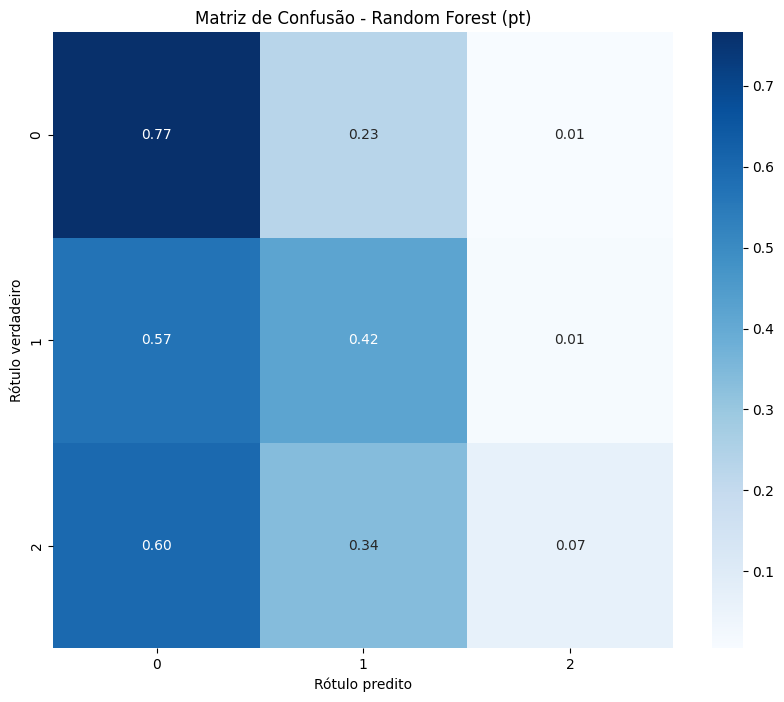

In [38]:


# Definir as classes do experimento E5


# Converter as previsões para classes discretas

#all_y_test_Deep, all_y_pred_Deep,
#classes = np.array([1, 2, 3, 5, 8, 13, 20, 40, 100])
classes = np.array([0, 1, 2])

# Gerar a matriz de confusão
matriz_confusao_rf = confusion_matrix(all_y_test_Deep, all_y_pred_Deep, labels=classes)

# Calcular a proporção para cada classe verdadeira (linha)
matriz_confusao_proporcao_rf = matriz_confusao_rf.astype('float') / matriz_confusao_rf.sum(axis=1)[:, np.newaxis]

# Exibir a matriz de confusão usando seaborn para visualização
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusao_proporcao_rf, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Rótulo predito')
plt.ylabel('Rótulo verdadeiro')
plt.title('Matriz de Confusão - Random Forest (pt)')
plt.show()

### REsultado com 5 classes

### Random Forest

### Ajustando a arquitetura do modelo

In [113]:
import random
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
# Função para definir seed globalmente
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

#implementando Focal Loss
# Função para implementar o Focal Loss
def focal_loss(gamma=2., alpha=None):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])

        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())  # Prevenindo log(0)
        cross_entropy = -y_true * tf.math.log(y_pred)

        if alpha is not None:
            alpha_tensor = tf.constant(alpha, dtype=tf.float32)
            alpha_factor = y_true * alpha_tensor
            cross_entropy *= alpha_factor

        weight = tf.pow(1. - y_pred, gamma)  # Focal loss weight
        loss = weight * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return focal_loss_fixed

# Inicializando listas para armazenar métricas e tempos
vetAccuracyDeep = []
vetPrecisionDeep = []
vetRecallDeep = []
vetF1Deep = []
vetBalancedAccuracyDeep = []  # Lista para armazenar a Balanced Accuracy
training_times = []
inference_times = []
all_y_test_Deep = []
all_y_pred_Deep = []

# Definindo o KFold para cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lista de seeds diferentes para testar
# Define uma seed mestra para gerar seeds aleatórias controladas
random.seed(42)
seeds = [random.randint(0, 100000) for _ in range(5)]
print("Seeds fixas e reprodutíveis:", seeds)

# Realizando múltiplos experimentos com diferentes seeds
for seed in seeds:
    print(f"Executando experimento com seed: {seed}")
    
    # Inicializando o seed
    set_seed(seed)




      # Inicializando listas para armazenar as métricas para cada seed
    vetAccuracyTemp = []
    vetPrecisionTemp = []
    vetRecallTemp = []
    vetF1Temp = []
    vetBalancedAccuracyTemp = []
    training_times_temp = []
    inference_times_temp = []

    # Definindo o KFold para cross-validation (você pode usar outro tipo de validacao se necessário)
    #kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X_truncated, y_encoded):  # X_truncated e y_encoded são os dados e rótulos
        print(X_truncated.shape)
        print(X_truncated.size)   
        x_train, x_test = X_truncated[train_index], X_truncated[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]
        print(np.unique(y_train))
        print(np.unique(y_test))
        print(x_train.shape)  # Para x_train
        print(x_test.shape)   # Para x_test
        n_sentence = 1
       

        classes = np.unique(y_train)
        weights = compute_class_weight('balanced', classes=classes, y=y_train)
        alpha = list(weights / np.sum(weights))  # Normaliza para somar 1

        # Adicionando as amostras sintéticas somente ao treino
        x_train = np.concatenate([x_train, synthetic_embeddings_norm], axis=0)
        y_train = np.concatenate([y_train, y_fake], axis=0)
        
        print("Treino balanceado:", Counter(y_train))
        print("Teste desbalanceado:", Counter(y_test))
        # Agora sim, faça o reshape após adicionar as amostras sintéticas
        x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

        # Redimensionando os dados
       # x_train = x_train.reshape(x_train.shape[0], n_sentence, x_train.shape[1])  # (38947, 1, 768)
        #smote = SMOTE(sampling_strategy={2: 9551}, random_state=42)
        #x_train_res, y_train_res = smote.fit_resample(x_train.reshape(x_train.shape[0], -1), y_train)
        #x_train_res = x_train_res.reshape(x_train_res.shape[0], n_sentence, -1)
        #x_test = x_test.reshape(x_test.shape[0], n_sentence, x_test.shape[1])  # (4328, 1, 768)

        # Aplicando SMOTE para balanceamento de classes no conjunto de treino
        #smote = SMOTE(random_state=42)
        #x_train_res, y_train_res = smote.fit_resample(x_train.reshape(x_train.shape[0], -1), y_train)
        #x_train_res = x_train_res.reshape(x_train_res.shape[0], n_sentence, -1)  # Redimensionando novamente após SMOTE
        #x_train = x_train.reshape(x_train.shape[0], -1)  # (38947, 1, 768)
        #x_test = x_test.reshape(x_test.shape[0], -1)  # (4328, 1, 768)
        #x_train = x_train.reshape(x_train.shape[0], 1, -1)  # Redimensionando os dados de entrada para (n_samples, 1, n_features)
        #x_test = x_test.reshape(x_test.shape[0], 1, -1)  # Redimensionando os dados de teste da mesma forma
        # Redimensionando os dados
       # x_train = x_train.reshape(x_train.shape[0], -1)  # (38947, 1, 768)
        #x_test = x_test.reshape(x_test.shape[0], -1)  # (4328, 1, 768)
         # Aplicando SMOTE para balanceamento de classes no conjunto de treino
        #smote = SMOTE(random_state=42)
       
        #x_train = x_train.reshape(x_train.shape[0], n_sentence, -1)  # Redimensionando para o formato correto
        # Definindo o modelo
        modelDeepClass = Sequential([
            SpatialDropout1D(0.2),
            Bidirectional(LSTM(200, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)),
            LSTM(100, dropout=0.3, recurrent_dropout=0.2),
            Dense(50, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

        adam = Adam(learning_rate=0.0005)

        modelDeepClass.compile(
            loss=focal_loss(gamma=2., alpha=alpha),
            optimizer=adam,
            metrics=['accuracy']
        )

        es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

        modelDeepClass.fit(
            x_train, y_train,
            batch_size=128,
            epochs=100,
            validation_data=(x_test, y_test),
            shuffle=True,
            callbacks=[es, lr_scheduler],
            verbose=1,
            class_weight=class_weight_dict
        )
        end_training = time.time()
        training_time = end_training - start_training
        #training_times.append(training_time)

        # Fazendo previsões e medindo o tempo
        start_inference = time.time()
        y_pred = modelDeepClass.predict(x_test)
        end_inference = time.time()
        inference_time = end_inference - start_inference
        #inference_times.append(inference_time)

        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculando métricas
        accuracy = accuracy_score(y_test, y_pred_classes)
        class_report = classification_report(y_test, y_pred_classes, output_dict=True)

        # Calculando a Balanced Accuracy
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred_classes)

        vetAccuracyTemp.append(accuracy)
        vetPrecisionTemp.append(class_report['macro avg']['precision'])
        vetRecallTemp.append(class_report['macro avg']['recall'])
        vetF1Temp.append(class_report['macro avg']['f1-score'])
        vetBalancedAccuracyTemp.append(balanced_accuracy)

        all_y_test_Deep.extend(y_test)
        all_y_pred_Deep.extend(y_pred_classes)
        training_times_temp.append(training_time)
        inference_times_temp.append(inference_time)

# Calculando a média e o desvio padrão para as métricas de cada seed
    vetAccuracyDeep.append(np.mean(vetAccuracyTemp))
    vetPrecisionDeep.append(np.mean(vetPrecisionTemp))
    vetRecallDeep.append(np.mean(vetRecallTemp))
    vetF1Deep.append(np.mean(vetF1Temp))
    vetBalancedAccuracyDeep.append(np.mean(vetBalancedAccuracyTemp))

    training_times.append(np.mean(training_times_temp))
    inference_times.append(np.mean(inference_times_temp))

# Relatório final de métricas
print(f"Média Accuracy: {np.nanmean(vetAccuracyDeep):.4f} ± {np.nanstd(vetAccuracyDeep):.4f}")
print(f"Média Precision: {np.nanmean(vetPrecisionDeep):.4f} ± {np.nanstd(vetPrecisionDeep):.4f}")
print(f"Média Recall: {np.nanmean(vetRecallDeep):.4f} ± {np.nanstd(vetRecallDeep):.4f}")
print(f"Média F1-Score: {np.mean(vetF1Deep):.4f} ± {np.nanstd(vetF1Deep):.4f}")
print(f"Média Balanced Accuracy: {np.nanmean(vetBalancedAccuracyDeep):.4f} ± {np.nanstd(vetBalancedAccuracyDeep):.4f}")
print(f"Tempo médio de treinamento: {np.nanmean(training_times):.2f} ± {np.nanstd(training_times):.2f} segundos")
print(f"Tempo médio de inferência: {np.nanmean(inference_times):.2f} ± {np.nanstd(inference_times):.2f} segundos")


Seeds fixas e reprodutíveis: [83810, 14592, 3278, 97196, 36048]
Executando experimento com seed: 83810
(23230, 768)
17840640
[0 1 2]
[0 1 2]
(20907, 768)
(2323, 768)
Treino balanceado: Counter({0: 11138, 2: 9419, 1: 8579})
Teste desbalanceado: Counter({0: 1238, 1: 953, 2: 132})
Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.5793 - loss: 0.1082 - val_accuracy: 0.3349 - val_loss: 0.0660 - learning_rate: 5.0000e-04
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5458 - loss: 0.0561 - val_accuracy: 0.5381 - val_loss: 0.0696 - learning_rate: 5.0000e-04
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5424 - loss: 0.0514 - val_accuracy: 0.4985 - val_loss: 0.0646 - learning_rate: 5.0000e-04
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5338 - loss: 0.0490 - val_accuracy: 0.5411 - val_loss: 0.0659 - learning_rate: 5.0000e-04
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5471 - loss: 0.0477 

In [114]:

# Relatório final de métricas
print(f"Média Accuracy: {np.nanmean(vetAccuracyDeep):.4f} ± {np.nanstd(vetAccuracyDeep):.4f}")
print(f"Média Precision: {np.nanmean(vetPrecisionDeep):.4f} ± {np.nanstd(vetPrecisionDeep):.4f}")
print(f"Média Recall: {np.nanmean(vetRecallDeep):.4f} ± {np.nanstd(vetRecallDeep):.4f}")
print(f"Média F1-Score: {np.mean(vetF1Deep):.4f} ± {np.nanstd(vetF1Deep):.4f}")
print(f"Média Balanced Accuracy: {np.nanmean(vetBalancedAccuracyDeep):.4f} ± {np.nanstd(vetBalancedAccuracyDeep):.4f}")
print(f"Tempo médio de treinamento: {np.nanmean(training_times):.2f} ± {np.nanstd(training_times):.2f} segundos")
print(f"Tempo médio de inferência: {np.nanmean(inference_times):.2f} ± {np.nanstd(inference_times):.2f} segundos")

Média Accuracy: 0.5474 ± 0.0050
Média Precision: 0.4512 ± 0.0061
Média Recall: 0.4166 ± 0.0089
Média F1-Score: 0.4106 ± 0.0129
Média Balanced Accuracy: 0.4166 ± 0.0089
Tempo médio de treinamento: 6848.24 ± 1026.69 segundos
Tempo médio de inferência: 2.11 ± 0.04 segundos
